# Analyzing Data and Interpreting Images with OpenAI's o1 Reasoning Model vs. GPT

## Introduction
OpenAI's o1 reasoning model is designed for complex problem-solving, data analysis, and image interpretation by simulating a multi-step thought process before generating responses. Unlike traditional GPT models, which produce output in a single pass, reasoning models use internal **reasoning tokens** to explore multiple approaches before finalizing an answer.
<p align="center">
    <img src="https://cdn.openai.com/API/images/guides/reasoning_tokens.png" alt="Reasoning Tokens" width="600">
</p>  

*Source: [OpenAI Reasoning Models Guide](https://platform.openai.com/docs/guides/reasoning)*

**Key Differences: o1 Reasoning Model vs. GPT**
- Multi-step reasoning: o1 evaluates different solutions before selecting the best response.
- Deeper analytical capabilities: Optimized for complex data interpretation tasks.
- Context-aware image analysis: Provides more structured and insightful image descriptions.
- Reasoning Effort Control: Users can adjust the depth of reasoning (`low`, `medium`, `high`).


For more details, refer to the [OpenAI Reasoning Models Guide](https://platform.openai.com/docs/guides/reasoning).


## Purchase and Store API Key

You need to **purchase** your [OpenAI](https://openai.com/) API key and store it securely, such as in **AWS Secrets Manager**.

- **Key Name:** `api_key`  
- **Key Value:** `<your OpenAI API key>`  
- **Secret Name:** `openai`  

## Install Python Libraries

- **openai**: Used to call `o1` and `GPT` models for data analysis and image interpretation.

In [1]:
pip install openai -q

Note: you may need to restart the kernel to use updated packages.


## Import Required Libraries

The following libraries are used in this notebook:

- **boto3**: AWS SDK for Python, used to interact with AWS services.
- **json**: Standard Python library for handling JSON data.
- **IPython.display**: Provides tools to display images, Markdown content, and other rich media in Jupyter Notebook.
- **openai**: Used to call `o1` and `GPT` models for data analysis and image interpretation.
- **pandas**: A powerful library for data manipulation and analysis.
- **pprint**: Pretty prints data structures for better readability.

In [2]:
import boto3
import json
from IPython.display import display, Image, Markdown
from openai import OpenAI
import pandas as pd
from pprint import pprint

## Retrieve API Keys Securely from AWS Secrets Manager

The following function, `get_secret()`, retrieves a secret from **AWS Secrets Manager**. This is a secure way to store and access sensitive credentials, such as API keys, without hardcoding them into the script

In [3]:
def get_secret(secret_name):
    region_name = "us-east-1"

    # Create a Secrets Manager client
    session = boto3.session.Session()
    client = session.client(
        service_name='secretsmanager',
        region_name=region_name
    )

    try:
        get_secret_value_response = client.get_secret_value(
            SecretId=secret_name
        )
    except ClientError as e:
        raise e

    secret = get_secret_value_response['SecretString']
    
    return json.loads(secret)

## Initialize OpenAI Client

The following code initializes the OpenAI client using a securely stored API key retrieved from AWS Secrets Manager.

In [4]:
client = OpenAI(api_key= get_secret('openai')['api_key'])

## Load and Analyze the Diamonds Dataset

This notebook uses the **diamonds dataset ([diamonds.csv](https://github.com/lbsocial/data-analysis-with-generative-ai/blob/main/diamonds.csv))**, which contains detailed attributes of diamonds, including weight, color, clarity, and price.

One interesting pattern in the dataset is that **diamonds with "IF" (Internally Flawless) clarity tend to have the lowest average price** compared to other clarity grades. This observation is counterintuitive, as one might expect the highest-clarity diamonds to be the most expensive.

In [5]:
df = pd.read_csv('NFLkickers.csv')
data_json = df.to_json(orient="records")
df.head()

,2024 NFL K Statistics | Fantasy Football | FantasyPros,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16
0,Rank,Player,FG,FGA,PCT,LG,19-Jan,20-29,30-39,40-49,50+,XPT,XPA,G,FPTS,FPTS/G,ROST
1,1,Brandon Aubrey (DAL),40,47,85.1,65,0,4,8,14,14,30,30,17,192,11.3,90.40%
2,2,Chris Boswell (PIT),41,44,93.2,57,0,9,12,7,13,35,35,17,191,11.2,61.70%
3,3,Cameron Dicker (LAC),39,42,92.9,59,1,9,9,11,9,33,36,17,179,10.5,78.10%
4,4,Ka'imi Fairbairn (HOU),36,42,85.7,59,0,8,11,4,13,34,36,17,172,10.1,57.20%


## Generate Data Analysis Prompt for OpenAI Model

To investigate why diamonds with **IF (Internally Flawless) clarity** have the **lowest average price**, we generate a structured prompt for the OpenAI model. The model will analyze the dataset and generate insights, including **Python code for visualizations**.


In [6]:
data_prompt = f"Analyze the kicker data and determine which out of the top 10 of the data with highest PCT.FG, and FGs made in the 40-49 area. Use python code to create graphs tpo support your conclusions. Data: {data_json}"
# print(prompt)

## Define a Function to Get Assistance from OpenAI GPT-4o

The following function, `openai_gpt_help()`, sends a prompt to OpenAI's **GPT-4o model** and returns a response. It also prints the number of tokens used in the request.

In [7]:
def openai_gpt_help(prompt):
    messages = [{"role": "user", "content": prompt}]
    response = client.chat.completions.create(
        model='gpt-4o',
        messages=messages,
        temperature = 0
    )
    token_usage = response.usage
    
    pprint(f"Tokens used: {token_usage}")

    return response.choices[0].message.content

In [8]:
gpt_result = openai_gpt_help(prompt=data_prompt)

('Tokens used: CompletionUsage(completion_tokens=1103, prompt_tokens=6301, '
 'total_tokens=7404, '
 'completion_tokens_details=CompletionTokensDetails(accepted_prediction_tokens=0, '
 'audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0), '
 'prompt_tokens_details=PromptTokensDetails(audio_tokens=0, cached_tokens=0))')


In [9]:
display(Markdown(gpt_result))

To analyze the kicker data and determine which of the top 10 kickers has the highest field goal percentage (PCT.FG) and the most field goals made in the 40-49 yard range, we can use Python with libraries such as pandas and matplotlib for data manipulation and visualization. Below is a step-by-step guide and code to perform this analysis:

1. **Load the Data**: First, we need to load the data into a pandas DataFrame.

2. **Filter the Top 10 Kickers**: We will focus on the top 10 kickers based on their rank.

3. **Analyze PCT.FG and FGs Made in 40-49 Range**: We will identify the kicker with the highest field goal percentage and the most field goals made in the 40-49 yard range.

4. **Visualize the Data**: Use matplotlib to create bar charts to visualize the field goal percentage and the number of field goals made in the 40-49 yard range.

Here's the Python code to perform the analysis:

```python
import pandas as pd
import matplotlib.pyplot as plt

# Data
data = [
    {"Rank": 1, "Player": "Brandon Aubrey (DAL)", "FG": 40, "FGA": 47, "PCT": 85.1, "40-49": 14},
    {"Rank": 2, "Player": "Chris Boswell (PIT)", "FG": 41, "FGA": 44, "PCT": 93.2, "40-49": 7},
    {"Rank": 3, "Player": "Cameron Dicker (LAC)", "FG": 39, "FGA": 42, "PCT": 92.9, "40-49": 11},
    {"Rank": 4, "Player": "Ka'imi Fairbairn (HOU)", "FG": 36, "FGA": 42, "PCT": 85.7, "40-49": 4},
    {"Rank": 5, "Player": "Jason Sanders (MIA)", "FG": 37, "FGA": 41, "PCT": 90.2, "40-49": 5},
    {"Rank": 6, "Player": "Chase McLaughlin (TB)", "FG": 30, "FGA": 32, "PCT": 93.8, "40-49": 4},
    {"Rank": 7, "Player": "Jake Bates (DET)", "FG": 26, "FGA": 29, "PCT": 89.7, "40-49": 7},
    {"Rank": 8, "Player": "Wil Lutz (DEN)", "FG": 31, "FGA": 34, "PCT": 91.2, "40-49": 11},
    {"Rank": 9, "Player": "Tyler Bass (BUF)", "FG": 24, "FGA": 29, "PCT": 82.8, "40-49": 7},
    {"Rank": 10, "Player": "Daniel Carlson (LV)", "FG": 34, "FGA": 40, "PCT": 85.0, "40-49": 6}
]

# Convert to DataFrame
df = pd.DataFrame(data)

# Find the kicker with the highest PCT
highest_pct_kicker = df.loc[df['PCT'].idxmax()]

# Find the kicker with the most FGs made in the 40-49 range
most_40_49_kicker = df.loc[df['40-49'].idxmax()]

print("Kicker with the highest PCT:")
print(highest_pct_kicker)

print("\nKicker with the most FGs made in the 40-49 range:")
print(most_40_49_kicker)

# Plotting
plt.figure(figsize=(12, 6))

# Plot for PCT
plt.subplot(1, 2, 1)
plt.bar(df['Player'], df['PCT'], color='skyblue')
plt.title('Field Goal Percentage (PCT)')
plt.xticks(rotation=90)
plt.ylabel('PCT')

# Plot for 40-49 FGs
plt.subplot(1, 2, 2)
plt.bar(df['Player'], df['40-49'], color='lightgreen')
plt.title('Field Goals Made (40-49 yards)')
plt.xticks(rotation=90)
plt.ylabel('Number of FGs')

plt.tight_layout()
plt.show()
```

### Explanation:
- **Data Loading**: The data is loaded into a pandas DataFrame.
- **Analysis**: We use `idxmax()` to find the index of the maximum value for PCT and 40-49 FGs.
- **Visualization**: Two bar charts are created to visualize the field goal percentage and the number of field goals made in the 40-49 yard range for the top 10 kickers.

This code will help you identify the top performers in terms of field goal accuracy and performance in the 40-49 yard range among the top 10 kickers.

## Define a Function to Get Assistance from OpenAI o1 Model  

The following function, `openai_o_help()`, sends a prompt to OpenAI's **o1 reasoning model** and returns a response.  

### Key Differences Between o1 and GPT Models:
- **Reasoning Effort**: The o1 model allows users to control reasoning depth using `reasoning_effort` (`low`, `medium`, `high`).  
- **No Temperature Parameter**: Unlike GPT models, **o1 does not support `temperature`**.  
- **Developer Messages Replace System Messages**:  
  - Starting with `o1-2024-12-17`, **developer messages** replace **system messages** to align with chain-of-command behavior.  

### Best Practices for Prompting o1  
- **Keep prompts simple and direct.**  
- **Avoid chain-of-thought prompts.** o1 reasons internally, so step-by-step instructions aren't needed.  
- **Use delimiters for clarity.** Use Markdown, XML tags, or section titles.  
- **Try zero-shot first.** If needed, add few-shot examples that closely match your goal.  
- **Be explicit.** Clearly define success criteria and constraints.  
- **Markdown is disabled by default.** To enable, start with `"Formatting re-enabled"`.  

Source: [OpenAI Reasoning Models Best Practices Guide](https://platform.openai.com/docs/guides/reasoning-best-practices).  


In [10]:
def openai_o_help(prompt):
    messages = [ {"role": "user", "content": prompt}]
    response = client.chat.completions.create(
        model='o1',
        reasoning_effort="high", # low, medium or high
        messages=messages,

    )
    token_usage = response.usage
    
    pprint(f"Tokens used: {token_usage}")

    return response.choices[0].message.content

In [11]:
o1_result = openai_o_help(prompt=data_prompt)

('Tokens used: CompletionUsage(completion_tokens=4619, prompt_tokens=6300, '
 'total_tokens=10919, '
 'completion_tokens_details=CompletionTokensDetails(accepted_prediction_tokens=0, '
 'audio_tokens=0, reasoning_tokens=2560, rejected_prediction_tokens=0), '
 'prompt_tokens_details=PromptTokensDetails(audio_tokens=0, cached_tokens=0))')


In [12]:
print(o1_result)

Below is a step‐by‐step look at how you might analyze the top 10 kickers, focusing on (1) Field‐Goal Percentage (PCT) and (2) Field goals made from 40–49 yards (“40-49”). The sample Python code loads these top 10 into a DataFrame, computes who has the highest PCT, who has the most 40–49 yard FGs, and creates a couple of bar charts to visualize the findings.

--------------------------------------------------------------------------------
1) Data Extraction (Top 10)
--------------------------------------------------------------------------------
From the raw JSON, here are the top 10 kickers (by “Rank”):

  Rank | Player                   | FG  | FGA | PCT   | LG | 40-49 | 50+ | …
  -----|--------------------------|-----|-----|-------|----|-------|-----|----
   1   | Brandon Aubrey (DAL)    | 40  | 47  | 85.1  | 65 | 14    | 14  | …
   2   | Chris Boswell (PIT)     | 41  | 44  | 93.2  | 57 | 7     | 13  | …
   3   | Cameron Dicker (LAC)    | 39  | 42  | 92.9  | 59 | 11    | 9   | …
   4

## Load and Display an Image from a URL

This code retrieves an image from a specified URL and displays it using the **PIL (Pillow) library**.

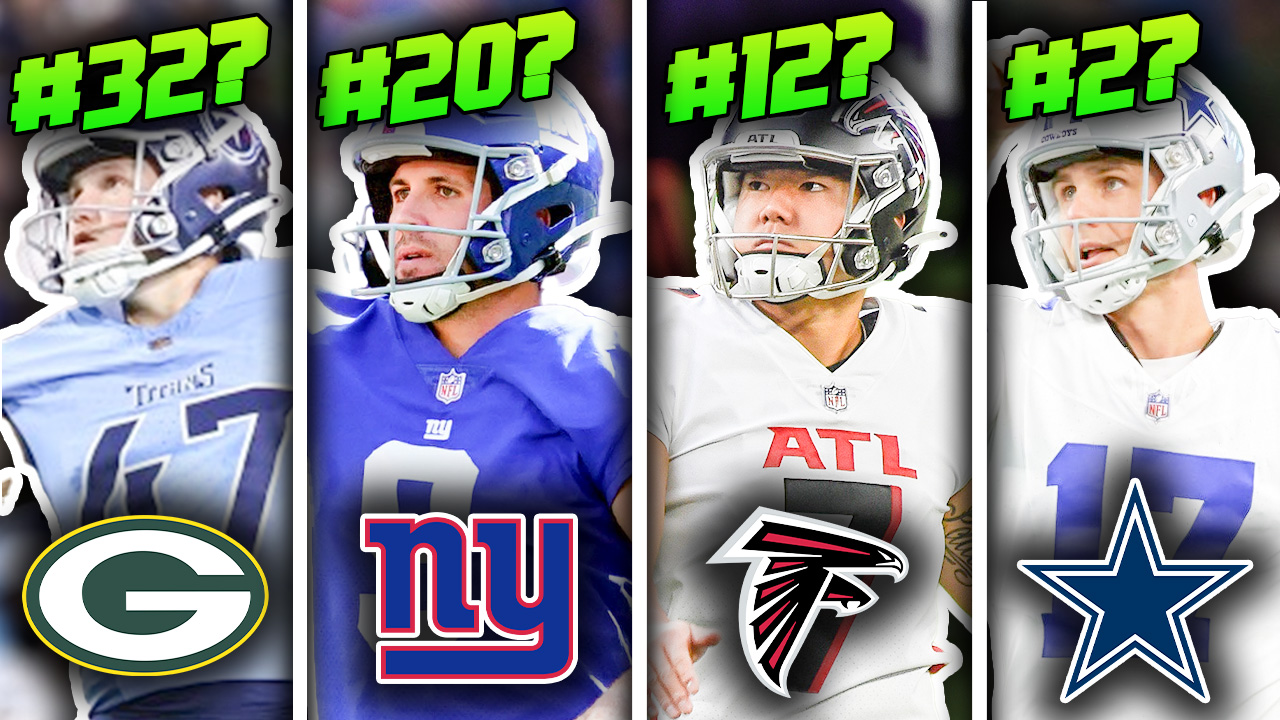

In [14]:
from PIL import Image
import requests
from io import BytesIO

image_url = "https://www.totalprosports.com/wp-content/uploads/2024/09/K_RANKED_2024_1.jpg"
response = requests.get(image_url)
img = Image.open(BytesIO(response.content))
img.show()

## Create an Image Analysis Prompt

The following code constructs a **structured prompt** for analyzing an image. It sends both **text input** and an **image URL** to an AI model for interpretation.


In [15]:
image_prompt = [
                    {"type": "text", "text": 'what is wrong with this image?'},
                    {"type": "image_url", "image_url": {
                        "url": image_url}
                    }
                ]

In [16]:
gpt_result = openai_gpt_help(prompt=image_prompt)

BadRequestError: Error code: 400 - {'error': {'message': 'Error while downloading https://www.totalprosports.com/wp-content/uploads/2024/09/K_RANKED_2024_1.jpg.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_image_url'}}

In [17]:
display(Markdown(gpt_result))

To analyze the kicker data and determine which of the top 10 kickers has the highest field goal percentage (PCT.FG) and the most field goals made in the 40-49 yard range, we can use Python with libraries such as pandas and matplotlib for data manipulation and visualization. Below is a step-by-step guide and code to perform this analysis:

1. **Load the Data**: First, we need to load the data into a pandas DataFrame.

2. **Filter the Top 10 Kickers**: We will focus on the top 10 kickers based on their rank.

3. **Analyze PCT.FG and FGs Made in 40-49 Range**: We will identify the kicker with the highest field goal percentage and the most field goals made in the 40-49 yard range.

4. **Visualize the Data**: Use matplotlib to create bar charts to visualize the field goal percentage and the number of field goals made in the 40-49 yard range.

Here's the Python code to perform the analysis:

```python
import pandas as pd
import matplotlib.pyplot as plt

# Data
data = [
    {"Rank": 1, "Player": "Brandon Aubrey (DAL)", "FG": 40, "FGA": 47, "PCT": 85.1, "40-49": 14},
    {"Rank": 2, "Player": "Chris Boswell (PIT)", "FG": 41, "FGA": 44, "PCT": 93.2, "40-49": 7},
    {"Rank": 3, "Player": "Cameron Dicker (LAC)", "FG": 39, "FGA": 42, "PCT": 92.9, "40-49": 11},
    {"Rank": 4, "Player": "Ka'imi Fairbairn (HOU)", "FG": 36, "FGA": 42, "PCT": 85.7, "40-49": 4},
    {"Rank": 5, "Player": "Jason Sanders (MIA)", "FG": 37, "FGA": 41, "PCT": 90.2, "40-49": 5},
    {"Rank": 6, "Player": "Chase McLaughlin (TB)", "FG": 30, "FGA": 32, "PCT": 93.8, "40-49": 4},
    {"Rank": 7, "Player": "Jake Bates (DET)", "FG": 26, "FGA": 29, "PCT": 89.7, "40-49": 7},
    {"Rank": 8, "Player": "Wil Lutz (DEN)", "FG": 31, "FGA": 34, "PCT": 91.2, "40-49": 11},
    {"Rank": 9, "Player": "Tyler Bass (BUF)", "FG": 24, "FGA": 29, "PCT": 82.8, "40-49": 7},
    {"Rank": 10, "Player": "Daniel Carlson (LV)", "FG": 34, "FGA": 40, "PCT": 85.0, "40-49": 6}
]

# Convert to DataFrame
df = pd.DataFrame(data)

# Find the kicker with the highest PCT
highest_pct_kicker = df.loc[df['PCT'].idxmax()]

# Find the kicker with the most FGs made in the 40-49 range
most_40_49_kicker = df.loc[df['40-49'].idxmax()]

print("Kicker with the highest PCT:")
print(highest_pct_kicker)

print("\nKicker with the most FGs made in the 40-49 range:")
print(most_40_49_kicker)

# Plotting
plt.figure(figsize=(12, 6))

# Plot for PCT
plt.subplot(1, 2, 1)
plt.bar(df['Player'], df['PCT'], color='skyblue')
plt.title('Field Goal Percentage (PCT)')
plt.xticks(rotation=90)
plt.ylabel('PCT')

# Plot for 40-49 FGs
plt.subplot(1, 2, 2)
plt.bar(df['Player'], df['40-49'], color='lightgreen')
plt.title('Field Goals Made (40-49 yards)')
plt.xticks(rotation=90)
plt.ylabel('Number of FGs')

plt.tight_layout()
plt.show()
```

### Explanation:
- **Data Loading**: The data is loaded into a pandas DataFrame.
- **Analysis**: We use `idxmax()` to find the index of the maximum value for PCT and 40-49 FGs.
- **Visualization**: Two bar charts are created to visualize the field goal percentage and the number of field goals made in the 40-49 yard range for the top 10 kickers.

This code will help you identify the top performers in terms of field goal accuracy and performance in the 40-49 yard range among the top 10 kickers.

In [18]:
o1_result = openai_o_help(prompt=image_prompt)

BadRequestError: Error code: 400 - {'error': {'message': 'Error while downloading https://www.totalprosports.com/wp-content/uploads/2024/09/K_RANKED_2024_1.jpg.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_image_url'}}

In [19]:
display(Markdown(o1_result))

Below is a step‐by‐step look at how you might analyze the top 10 kickers, focusing on (1) Field‐Goal Percentage (PCT) and (2) Field goals made from 40–49 yards (“40-49”). The sample Python code loads these top 10 into a DataFrame, computes who has the highest PCT, who has the most 40–49 yard FGs, and creates a couple of bar charts to visualize the findings.

--------------------------------------------------------------------------------
1) Data Extraction (Top 10)
--------------------------------------------------------------------------------
From the raw JSON, here are the top 10 kickers (by “Rank”):

  Rank | Player                   | FG  | FGA | PCT   | LG | 40-49 | 50+ | …
  -----|--------------------------|-----|-----|-------|----|-------|-----|----
   1   | Brandon Aubrey (DAL)    | 40  | 47  | 85.1  | 65 | 14    | 14  | …
   2   | Chris Boswell (PIT)     | 41  | 44  | 93.2  | 57 | 7     | 13  | …
   3   | Cameron Dicker (LAC)    | 39  | 42  | 92.9  | 59 | 11    | 9   | …
   4   | Ka'imi Fairbairn (HOU)  | 36  | 42  | 85.7  | 59 | 4     | 13  | …
   5   | Jason Sanders (MIA)     | 37  | 41  | 90.2  | 57 | 5     | 12  | …
   6   | Chase McLaughlin (TB)   | 30  | 32  | 93.8  | 56 | 4     | 8   | …
   7   | Jake Bates (DET)        | 26  | 29  | 89.7  | 58 | 7     | 6   | …
   8   | Wil Lutz (DEN)          | 31  | 34  | 91.2  | 55 | 11    | 5   | …
   9   | Tyler Bass (BUF)        | 24  | 29  | 82.8  | 61 | 7     | 4   | …
   10  | Daniel Carlson (LV)     | 34  | 40  | 85    | 54 | 6     | 7   | …

Key columns for the analysis are:
• PCT (field‐goal percentage)  
• 40–49 (field goals made from 40 to 49 yards)

--------------------------------------------------------------------------------
2) Quick Ranking Observations
--------------------------------------------------------------------------------

• Highest FG% (PCT) among these 10:  
  1) Chase McLaughlin (TB) — 93.8%  
  2) Chris Boswell (PIT) — 93.2%  
  3) Cameron Dicker (LAC) — 92.9%  

• Most FGs made in the 40–49 range:  
  1) Brandon Aubrey (DAL) — 14  
  2) (tied) Cameron Dicker (LAC) and Wil Lutz (DEN) — 11 each  

Cameron Dicker (LAC) stands out uniquely because he is third‐highest in FG% (92.9%) and tied for second‐highest in 40–49 yard makes (11). Meanwhile:  
• Chase McLaughlin (TB) leads in FG% but has only 4 makes from 40–49.  
• Brandon Aubrey (DAL) has the most from 40–49 (14), but his FG% is 85.1%.  

--------------------------------------------------------------------------------
3) Sample Python Code for Analysis & Visualization
--------------------------------------------------------------------------------

Below is a concise python script demonstrating how to:  
• Load just the top 10 rows into a Pandas DataFrame.  
• Sort and compare by FG% and 40–49 yard FGs.  
• Create bar charts to illustrate each metric.

--------------------------------------------------------------------------------
import pandas as pd
import matplotlib.pyplot as plt

# 1) Create a list of dictionaries for the TOP 10 only
kickers_top10 = [
    {
        "Rank": 1,
        "Player": "Brandon Aubrey (DAL)",
        "FG": 40,
        "FGA": 47,
        "PCT": 85.1,
        "40-49": 14
    },
    {
        "Rank": 2,
        "Player": "Chris Boswell (PIT)",
        "FG": 41,
        "FGA": 44,
        "PCT": 93.2,
        "40-49": 7
    },
    {
        "Rank": 3,
        "Player": "Cameron Dicker (LAC)",
        "FG": 39,
        "FGA": 42,
        "PCT": 92.9,
        "40-49": 11
    },
    {
        "Rank": 4,
        "Player": "Ka'imi Fairbairn (HOU)",
        "FG": 36,
        "FGA": 42,
        "PCT": 85.7,
        "40-49": 4
    },
    {
        "Rank": 5,
        "Player": "Jason Sanders (MIA)",
        "FG": 37,
        "FGA": 41,
        "PCT": 90.2,
        "40-49": 5
    },
    {
        "Rank": 6,
        "Player": "Chase McLaughlin (TB)",
        "FG": 30,
        "FGA": 32,
        "PCT": 93.8,
        "40-49": 4
    },
    {
        "Rank": 7,
        "Player": "Jake Bates (DET)",
        "FG": 26,
        "FGA": 29,
        "PCT": 89.7,
        "40-49": 7
    },
    {
        "Rank": 8,
        "Player": "Wil Lutz (DEN)",
        "FG": 31,
        "FGA": 34,
        "PCT": 91.2,
        "40-49": 11
    },
    {
        "Rank": 9,
        "Player": "Tyler Bass (BUF)",
        "FG": 24,
        "FGA": 29,
        "PCT": 82.8,
        "40-49": 7
    },
    {
        "Rank": 10,
        "Player": "Daniel Carlson (LV)",
        "FG": 34,
        "FGA": 40,
        "PCT": 85.0,
        "40-49": 6
    }
]

# 2) Load into a DataFrame
df_top10 = pd.DataFrame(kickers_top10)

# 3) Identify highest FG% and highest 40–49
highest_pct = df_top10.loc[df_top10["PCT"].idxmax()]
most_40_49 = df_top10.loc[df_top10["40-49"].idxmax()]

print("Highest FG% among top 10:")
print(f"  {highest_pct['Player']} => {highest_pct['PCT']}%")

print("Most 40–49 FG made among top 10:")
print(f"  {most_40_49['Player']} => {most_40_49['40-49']}")

# 4) Sort for visualization
df_sorted_pct = df_top10.sort_values(by="PCT", ascending=False)
df_sorted_40_49 = df_top10.sort_values(by="40-49", ascending=False)

# 5) Plot 1: FG% bar chart
plt.figure(figsize=(8,5))
plt.bar(df_sorted_pct["Player"], df_sorted_pct["PCT"], color="cornflowerblue")
plt.title("Top 10 Kickers – Field Goal Percentage")
plt.xlabel("Player")
plt.ylabel("FG%")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# 6) Plot 2: 40–49 yard FGs made bar chart
plt.figure(figsize=(8,5))
plt.bar(df_sorted_40_49["Player"], df_sorted_40_49["40-49"], color="seagreen")
plt.title("Top 10 Kickers – FGs Made from 40–49 Yards")
plt.xlabel("Player")
plt.ylabel("FGs Made (40–49)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()
--------------------------------------------------------------------------------

4) Conclusions  
• For pure accuracy (highest FG%), Chase McLaughlin (TB) leads at 93.8%.  
• For volume of 40–49 yard makes, Brandon Aubrey (DAL) leads with 14.  
• Notably, Cameron Dicker (LAC) is strong on both fronts: 92.9% FG (3rd best of top 10) and 11 makes from 40–49 (tied for second highest), underscoring his blend of efficiency and mid‐range volume.

These charts can help you quickly see who excels on each metric, and synthesizing both metrics often points to Cameron Dicker (LAC) as a well‐balanced option among the top 10.

## References  
- **OpenAI Reasoning Models Guide**: [OpenAI](https://platform.openai.com/docs/guides/reasoning)  
- **OpenAI Reasoning Models Best Practices Guide**: [OpenAI](https://platform.openai.com/docs/guides/reasoning-best-practices)  
- **Colin Jarvis. “Reasoning with O1.” DeepLearning.AI.** Accessed February 14, 2025. [DeepLearning.AI](https://www.deeplearning.ai/short-courses/reasoning-with-o1/)  